In [1]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict
import seaborn as sns
sns.set_palette("dark")

In [2]:
os.chdir("../../java")

In [3]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_truncation": "C6",
    
    "dyadic_b4": "C1",
    "dyadic_b10": "C2",

    "q_cooperative": "C0",
    "q_truncation": "C1",
    "q_pps": "C2",
    "q_random_sample": "C3",
    "q_dyadic_b2": "C6",
    
    "spacesaving": "C4",
    "cms_min": "C5",
    "kll": "C4",
    "low_discrep": "C5",
    "yahoo_mg": "C7",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    
    "dyadic_truncation": "<",
    "dyadic_b4": "^",
    "dyadic_b10": "+",

    "q_cooperative": "x",
    "q_truncation": "^",
    "q_pps": "s",
    "q_random_sample": "+",
    "q_dyadic_b2": "<",

    "spacesaving": "D",
    "cms_min": "o",
    "kll": "D",
    "low_discrep": "o",
    "yahoo_mg": "*",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Truncation",
    "pps": "PPS",
    "random_sample": "USample",
    
    "dyadic_truncation": "Hierarchy",
    "dyadic_b4": "Hierarchy $b=4$",
    "dyadic_b10": "Hierarchy $b=10$",

    "q_cooperative": "Cooperative",
    "q_truncation": "Truncation",
    "q_pps": "PPS",
    "q_random_sample": "USample",
    "q_dyadic_b2": "Hierachy",

    "spacesaving": "SpaceSaving",
    "cms_min": "CMS",
    "kll": "KLL",
    "low_discrep": "LowDiscrep",
    "yahoo_mg": "MG"
}
data_display_name = {
    "caida_10M": "CAIDA",
    "zipf1p1_10M": "Zipf",
    "msft_network_10M": "Provider",
    "msft_os_10M": "OSBuild",
    "power_2M": "Power",
    "uniform_1M": "Uniform",
    "msft_records_10M": "Traffic",
}

In [4]:
def get_error_file(experiment_name):
    return os.path.join(
        "output/results/{}".format(experiment_name),
        "errors.csv"
    )

In [5]:
def query_length_plot(
    experiment_name,
    sketch_names: List,
    item_agg="max",
    query_agg="mean",
    ax = None,
    absolute=False,
):
    e_combined = pd.read_csv(get_error_file(experiment_name))
    e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    if absolute:
        e_combined["e_norm"] = e_combined[item_agg]
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            color=colormap[method],
            markersize=5,
            lw=.5,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

In [6]:
def query_time_plot(
    experiment_name,
    sketch_names: List,
    ax = None,
):
    e_combined = pd.read_csv(get_error_file(experiment_name))
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "query_time": ["mean", "std", "max", "count"],
    })
    eg["time"] = eg[("query_time", "mean")]
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.plot(
            eg_cur.index,
            eg_cur["time"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


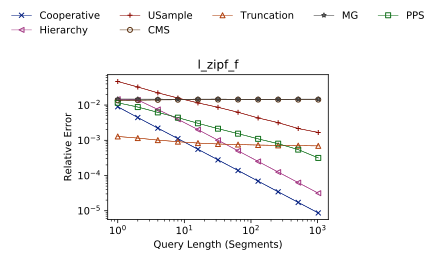

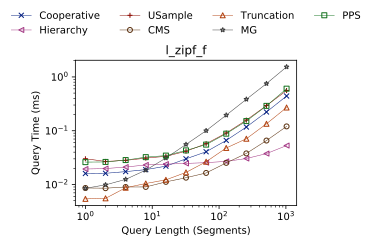

In [11]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "cms_min", 
    "truncation", 
    "yahoo_mg",
    "pps"
]
sketch_size = 64
experiments = [
    "l_zipf_f",
    "l_caida_f",
    "l_mos_f",
    "l_mnetwork_f",
]
cur_experiment = experiments[0]

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_length_plot(
    cur_experiment,
    sketch_names,
    item_agg="max",
    query_agg="mean",
    ax=ax,
    absolute=False,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Relative Error")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()
# fname = "output/plots/linear_freq.pdf"
# fname = "output/{}/query_error.png".format(cur_experiment)
# fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_time_plot(
    cur_experiment,
    sketch_names,
    ax=ax,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Query Time (ms)")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.4), ncol=4)
fig.show()
# fname = "output/{}/query_time.png".format(cur_experiment)
# fig.savefig(fname, dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


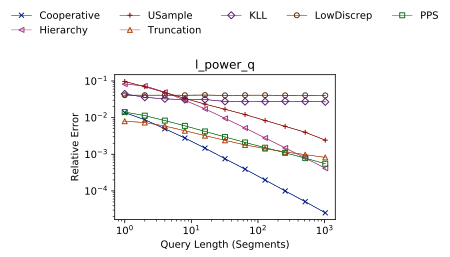

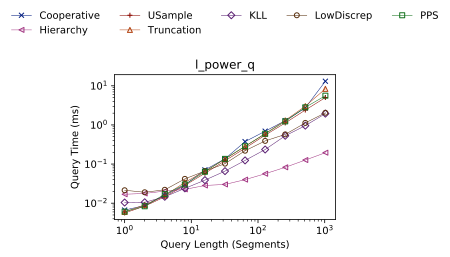

In [12]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
#     "dyadic_b3",
    "random_sample", 
    "truncation", 
    "kll",
    "low_discrep",
    "pps"
]
sketch_size = 64
experiments = [
    "l_power_q",
    "l_mrecords_q",
    "l_uniform_q",
]
cur_experiment = experiments[0]

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_length_plot(
    cur_experiment,
    sketch_names,
    item_agg="max",
    query_agg="mean",
    ax=ax,
    absolute=False,
)
ax.set_title(cur_experiment)

ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Relative Error")


fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()
# fname = "output/plots/linear_freq.pdf"
# fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_time_plot(
    cur_experiment,
    sketch_names,
    ax=ax,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Query Time (ms)")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()

# Varying Segments

In [13]:
enames = [
    "l_caida_f",
    "l_caidaseg1_f",
    "l_caidaseg2_f"
]
dfs = [
    pd.read_csv(get_error_file(en))
    for en in enames
]
df = pd.concat(dfs).reset_index(drop=True)
df["adj_query_len"] = df["granularity"] / df["query_len"]
df_sel = df[df["adj_query_len"] == 4.0]
df_sel.groupby(["sketch", "granularity"]).aggregate({
    "max": ["mean"]
})

max
                                        mean
sketch            granularity               
cms_min           512            8864.606000
                  2048          41189.136000
                  8192         157577.908000
cooperative       512              56.264778
                  2048             69.915433
                  8192             67.749471
dyadic_truncation 512             285.040000
                  2048            346.280000
                  8192            394.792000
pps               512             643.506030
                  2048           1517.987095
                  8192           2078.955823
random_sample     512            2728.976469
                  2048           3107.290125
                  8192           3069.208000
truncation        512             938.656000
                  2048           2851.556000
                  8192          10262.098000
yahoo_mg          512           12654.894000
                  2048          49653.444000
                  8192         184656.404000

# Varying Size

In [14]:
fnames = [
    "l_zipfsize_f",
    "l_caidasize_f",
]
df = pd.read_csv(get_error_file(fnames[1]))

In [15]:
df_sel = df[df["query_len"] == 512]

In [9]:
df_sel.groupby(["sketch", "size"]).aggregate({
    "max": ["mean"]
})

max
                                 mean
sketch            size               
cms_min           4     633747.016000
                  8     311017.734000
                  16    157424.350000
                  32     78339.338000
                  64     41189.136000
                  128    17918.776000
                  256     8869.980000
                  512     4211.832000
cooperative       4        934.592667
                  8        584.351929
                  16       292.673702
                  32       144.942655
                  64        69.915433
                  128       33.698631
                  256       14.982283
                  512        7.280715
dyadic_truncation 4       3857.840000
                  8       2293.236000
                  16      1148.360000
                  32       607.026000
                  64       346.280000
                  128      179.868000
                  256       93.308000
                  512       47.758000
pps               4      11380.849667
                  8       7107.298714
                  16      4589.149071
                  32      2783.279800
                  64      1517.987095
                  128      617.902428
                  256      291.387819
                  512      112.082689
random_sample     4      13320.203000
                  8      11554.907500
                  16      5024.419750
                  32      4406.382375
                  64      3107.290125
                  128     1977.768812
                  256     1493.980391
                  512     1072.279359
truncation        4      16462.596000
                  8      13831.580000
                  16     10444.324000
                  32      6901.708000
                  64      2851.556000
                  128     1604.798000
                  256      656.650000
                  512      259.572000
yahoo_mg          4     285369.906000
                  8     281594.464000
                  16    181953.188000
                  32     96801.370000
                  64     49653.444000
                  128    25391.894000
                  256    12738.386000
                  512     5962.982000

# Accumulator

In [16]:
df = pd.read_csv(get_error_file("l_poweracc_q"))

In [17]:
df_sel = df[df["query_len"] == 512]

In [18]:
df_sel.groupby(["sketch", "accumulator_size"]).aggregate({
    "max": ["mean"]
})

max
                                            mean
sketch            accumulator_size              
cooperative       64                40653.242182
                  128               34361.889485
                  512                7391.453096
                  1000               2589.590240
                  2000                596.342101
                  10000                24.920000
                  100000               24.920000
                  1000000              24.920000
dyadic_truncation 64                  404.220000
                  128                 404.220000
                  512                 404.220000
                  1000                404.220000
                  2000                404.220000
                  10000               404.220000
                  100000              404.220000
                  1000000             404.220000
kll               64                14052.590000
                  128               14087.650000
                  512               14226.470000
                  1000              13683.830000
                  2000              14375.520000
                  10000             14086.600000
                  100000            13758.760000
                  1000000           14254.080000
low_discrep       64                21256.670000
                  128               21490.770000
                  512               21810.800000
                  1000              21165.590000
                  2000              21371.940000
                  10000             20697.390000
                  100000            21471.640000
                  1000000           20587.670000
pps               64                40646.746252
                  128               33726.313373
                  512                7442.463513
                  1000               2488.235499
                  2000                657.855158
                  10000               402.080000
                  100000              402.080000
                  1000000             402.080000
random_sample     64                41471.662477
                  128               31561.122861
                  512                7416.632856
                  1000               3247.863791
                  2000               2147.705053
                  10000              2065.537500
                  100000             2065.537500
                  1000000            2065.537500
truncation        64                39964.249832
                  128               32722.834693
                  512                7508.224354
                  1000               2519.760459
                  2000                724.046093
                  10000               489.550000
                  100000              489.550000
                  1000000             489.550000

# Cubes

In [8]:
df = pd.read_csv(get_error_file("c_bcube_f"))
df["err_n"] = df["max"] / df["total"]
dfg = df.groupby(["sketch"]).aggregate({"err_n": "mean"})

In [9]:
dfg

,err_n
sketch,
cms_min,0.077889
pps,0.003145
pps_coop,0.001646
random_sample,0.007762
random_sample_prop,0.005064
random_sample_strat,0.005122
truncation,0.003062
yahoo_mg,0.029624


In [29]:
df = pd.read_csv(get_error_file("c_bcube_lesion_f"))
df["err_n"] = df["max"] / df["total"]
dfg = df.groupby(["sketch", "workload_query_prob"]).aggregate({"err_n": "mean"})
dfg

err_n
sketch             workload_query_prob          
pps_coop           0.05                 0.000533
                   0.10                 0.000828
                   0.30                 0.002962
                   0.40                 0.004953
                   0.50                 0.007705
pps_nobias         0.05                 0.000556
                   0.10                 0.000884
                   0.30                 0.003144
                   0.40                 0.005211
                   0.50                 0.008021
pps_nosize         0.05                 0.001080
                   0.10                 0.001513
                   0.30                 0.004179
                   0.40                 0.006341
                   0.50                 0.009121
random_sample_coop 0.05                 0.002853
                   0.10                 0.003591
                   0.30                 0.009228
                   0.40                 0.014099
                   0.50                 0.020637